In [1]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.1

In [2]:
!pip install mediapipe scikit-learn matplotlib


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import metrics, optimizers, Sequential, activations, callbacks
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import keras.backend as K
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_dir = '/kaggle/input/synthetic-asl-alphabet/Train_Alphabet'
test_dir = '/kaggle/input/synthetic-asl-alphabet/Test_Alphabet'

In [5]:
def load_df(dir_path):
    df = {
        'filename': [],
        'label': []
    }
    classes = os.listdir(dir_path)
    for c in classes:
        path = dir_path + '/' + c

        img_paths = os.listdir(path)

        for img_path in img_paths:
            df['filename'].append(c + '/' + img_path)
            df['label'].append(c)
        
    df = pd.DataFrame(df)
    return df

train_df = load_df(train_dir)
test_df = load_df(test_dir)

In [6]:
train_df.sample(15)

,filename,label
33,N/66bf2cdc-9912-4c1e-affc-5cf9e3d1bf79.rgb_000...,N
8940,X/90eff511-95ee-4c0d-b218-bb22755477e7.rgb_000...,X
1103,R/1b4a5c3b-197c-444a-9433-fcc4e5ddf26f.rgb_000...,R
5187,H/9fa5e209-7b55-4071-8ace-7ed6b24d6dbd.rgb_000...,H
15060,A/955d4342-005f-4e37-af83-1753e0f0051e.rgb_000...,A
20585,P/e2f61183-10ea-472a-85e2-48e25967a934.rgb_000...,P
21404,L/63bf637e-19f8-4cc0-8160-698c5033a875.rgb_000...,L
21205,L/9dbdd505-d6f8-444f-bc6a-d69b297e33d0.rgb_000...,L
5487,E/5dd886d1-b456-42a4-af70-13ec077d03eb.rgb_000...,E
8869,X/1eeada87-1a76-4ac3-9cad-391abfd887b8.rgb_000...,X


In [7]:
train_df['label'].value_counts()

label
N        900
R        900
B        900
I        900
F        900
H        900
E        900
U        900
M        900
X        900
K        900
Q        900
Y        900
Blank    900
S        900
G        900
A        900
O        900
T        900
V        900
Z        900
C        900
P        900
L        900
W        900
D        900
J        900
Name: count, dtype: int64

In [8]:
def show_img(path, row):
    filename = list(row['filename'])[0]
    label = list(row['label'])[0]
    image = cv2.imread(path + '/' + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()

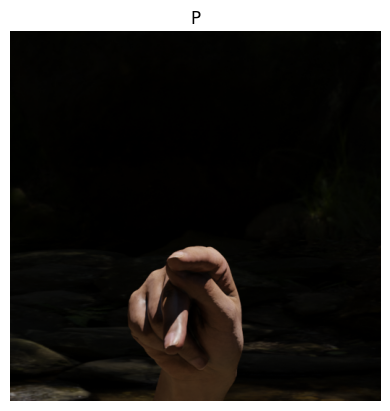

In [9]:
show_img(train_dir, train_df.sample(2))

In [10]:
X = train_df['filename']
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)

(19440,)
(4860,)


In [11]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = test_df

In [12]:
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     brightness_range=[0.5, 1.0],
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode='sparse',
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=IMAGE_SIZE
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    # color_mode="rgb",
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 19440 validated image filenames belonging to 27 classes.
Found 4860 validated image filenames belonging to 27 classes.
Found 2700 validated image filenames.


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Update the filename to use `.keras` extension
cb = [ModelCheckpoint('model_resnet.keras', save_best_only=True, monitor='val_loss')]


In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
n_class = 27

base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,), name='input_layer')
out = base_model(inputs, training=False)
out = GlobalAveragePooling2D()(out)
out = Dense(128, activation='relu')(out)
# out = Dropout(0.2)(out)
out = Dense(n_class, activation='softmax', name='output_layer')(out)
model_resnet = keras.Model(inputs, out)

model_resnet.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.Adamax(learning_rate=1e-4),
                     metrics=['accuracy'])

model_resnet.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,830,555 (90.91 MB)

 Trainable params: 265,755 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [15]:
history_resnet = model_resnet.fit(train_generator, epochs=20,
                                  validation_data=valid_generator,
                                  batch_size=120,
                                  callbacks=cb)

Epoch 1/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - accuracy: 0.1411 - loss: 3.0899 - val_accuracy: 0.4551 - val_loss: 2.0856
Epoch 2/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 435s 709ms/step - accuracy: 0.5222 - loss: 1.8627 - val_accuracy: 0.6397 - val_loss: 1.4044
Epoch 3/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 710ms/step - accuracy: 0.6703 - loss: 1.2848 - val_accuracy: 0.7066 - val_loss: 1.0900
Epoch 4/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 434s 707ms/step - accuracy: 0.7431 - loss: 1.0167 - val_accuracy: 0.7609 - val_loss: 0.9222
Epoch 5/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 429s 699ms/step - accuracy: 0.7787 - loss: 0.8585 - val_accuracy: 0.7782 - val_loss: 0.8131
Epoch 6/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 427s 696ms/step - accuracy: 0.8051 - loss: 0.7538 - val_accuracy: 0.8029 - val_loss: 0.7375
Epoch 7/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 430s 701ms/step - accuracy: 0.8223 - loss: 0.6869 - val_accuracy: 0.8193 - val_loss: 0.6795
Epoch 8/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 434s 707ms/step - accuracy: 0.8328 - lo

In [16]:
history_resnet_temp = history_resnet

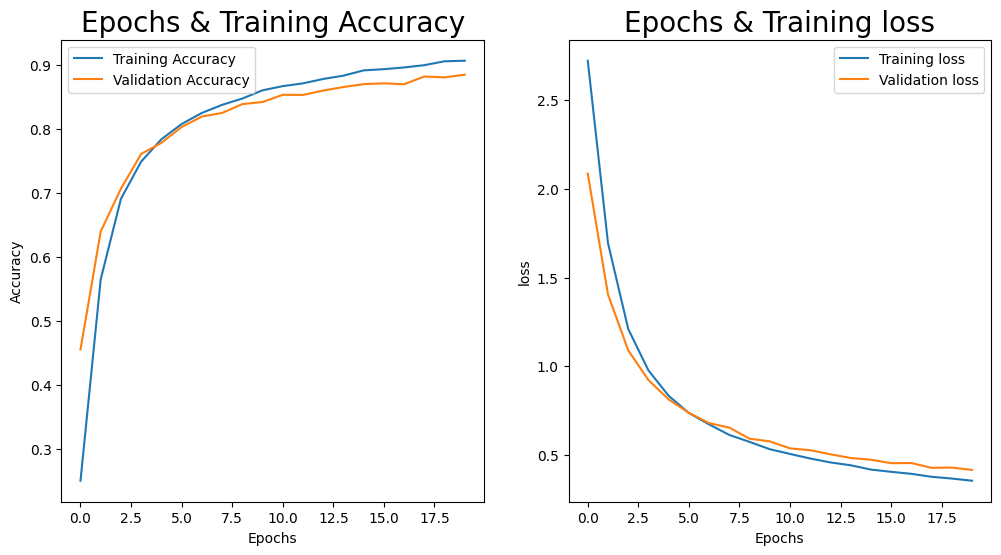

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet_temp.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet_temp.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet_temp.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet_temp.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [18]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 56s 19ms/step


In [19]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [20]:
accuracy_score(test['label'], pred_resnet)

0.9062962962962963

In [21]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.96      0.92      0.94       100
           B       0.94      0.87      0.90       100
       Blank       1.00      0.98      0.99       100
           C       0.95      0.94      0.94       100
           D       0.89      0.87      0.88       100
           E       0.86      0.89      0.88       100
           F       0.94      0.94      0.94       100
           G       0.97      0.96      0.96       100
           H       0.96      0.97      0.97       100
           I       0.89      0.91      0.90       100
           J       0.92      0.96      0.94       100
           K       0.84      0.90      0.87       100
           L       0.97      0.92      0.94       100
           M       0.78      0.74      0.76       100
           N       0.78      0.85      0.81       100
           O       0.89      0.91      0.90       100
           P       0.95      0.97      0.96       100
           Q       0.97    

In [22]:
model_resnet.save('resnet50v2_20_ep.hdf5')

In [23]:
history_resnet = model_resnet.fit(train_generator,
                                  initial_epoch=20,
                                  epochs=30,
                                  validation_data=valid_generator,
                                  batch_size=120,
                                  callbacks=cb)

Epoch 21/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 433s 705ms/step - accuracy: 0.9051 - loss: 0.3444 - val_accuracy: 0.8815 - val_loss: 0.4213
Epoch 22/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 434s 707ms/step - accuracy: 0.9115 - loss: 0.3402 - val_accuracy: 0.8827 - val_loss: 0.4094
Epoch 23/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 432s 704ms/step - accuracy: 0.9120 - loss: 0.3319 - val_accuracy: 0.8856 - val_loss: 0.4000
Epoch 24/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 435s 709ms/step - accuracy: 0.9121 - loss: 0.3164 - val_accuracy: 0.8870 - val_loss: 0.3891
Epoch 25/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 432s 704ms/step - accuracy: 0.9198 - loss: 0.3105 - val_accuracy: 0.8866 - val_loss: 0.3864
Epoch 26/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 433s 706ms/step - accuracy: 0.9196 - loss: 0.3045 - val_accuracy: 0.8934 - val_loss: 0.3777
Epoch 27/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 431s 702ms/step - accuracy: 0.9165 - loss: 0.3029 - val_accuracy: 0.8895 - val_loss: 0.3791
Epoch 28/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 435s 710ms/step - accuracy: 

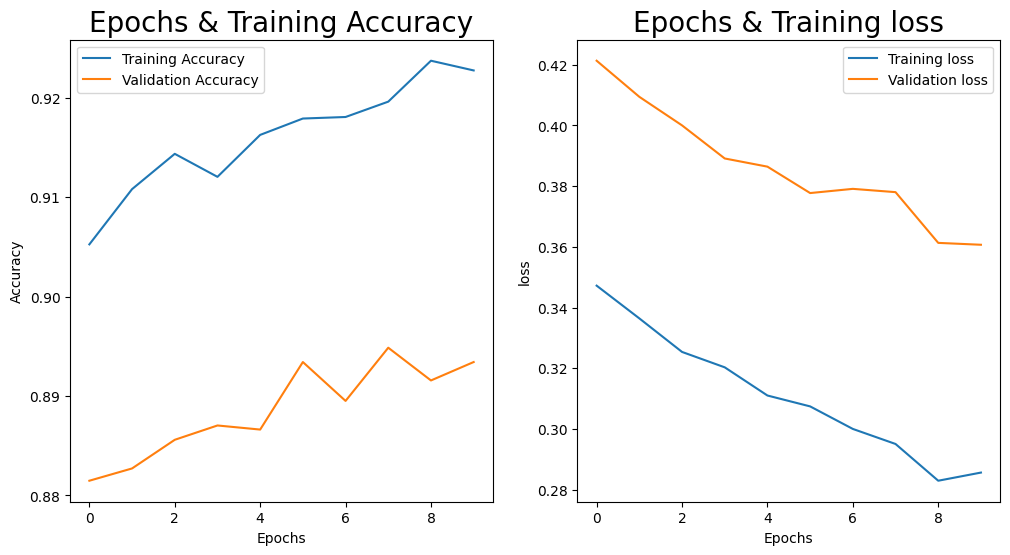

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [25]:
def concate_history(metric='accuracy', history1=history_resnet_temp, 
                    history2=history_resnet):
    history = pd.concat([pd.DataFrame(history1.history[metric]),
                        pd.DataFrame(history2.history[metric])])
    history.columns = [metric]
    history.reset_index(drop=True, inplace=True)
    
    return history

In [26]:
# Accuracy
acc_history = concate_history()

# Validation Accuracy
val_acc_history = concate_history('val_accuracy')

# Loss
loss_history = concate_history('loss')

# Validation Loss
val_loss_history = concate_history('val_loss')

In [27]:
full_history = pd.DataFrame({
    'accuracy' : acc_history['accuracy'].tolist(),
    'val_accuracy' : val_acc_history['val_accuracy'].tolist() ,
    'loss' : loss_history['loss'].tolist() ,
    'val_loss' : val_loss_history['val_loss'].tolist()
}, index=[_ for _ in range(30)])

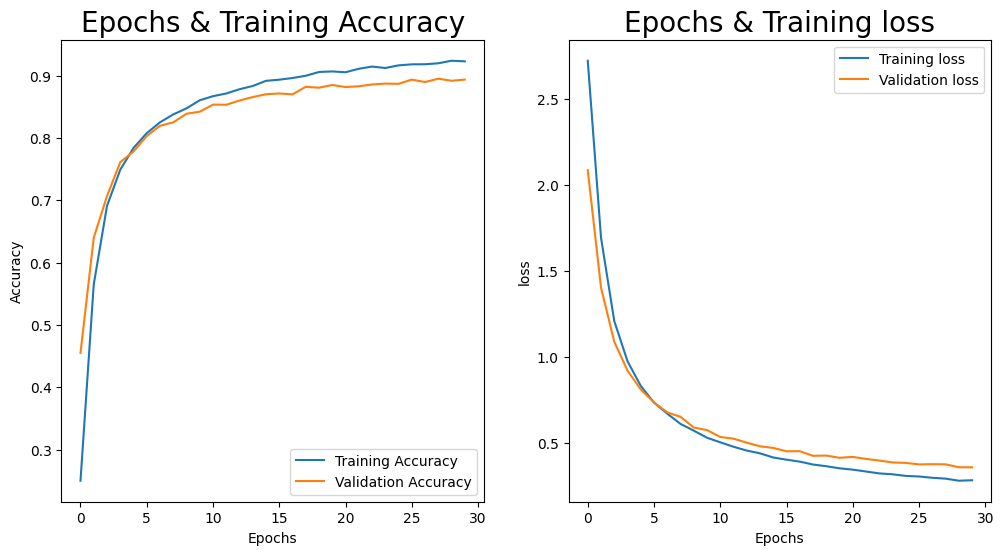

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(full_history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(full_history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(full_history['loss'], '-', label = 'Training loss')
ax[1].plot(full_history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [29]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step


In [30]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [31]:
accuracy_score(test['label'], pred_resnet)

0.9159259259259259

In [32]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.94      0.97      0.96       100
           B       0.97      0.91      0.94       100
       Blank       0.99      0.98      0.98       100
           C       0.95      0.93      0.94       100
           D       0.93      0.88      0.90       100
           E       0.89      0.94      0.91       100
           F       0.92      0.95      0.94       100
           G       0.95      0.99      0.97       100
           H       0.98      0.97      0.97       100
           I       0.88      0.92      0.90       100
           J       0.91      0.97      0.94       100
           K       0.87      0.88      0.88       100
           L       0.99      0.93      0.96       100
           M       0.86      0.75      0.80       100
           N       0.83      0.86      0.84       100
           O       0.90      0.93      0.92       100
           P       0.95      0.98      0.97       100
           Q       0.99    

In [33]:
model_resnet.save('finalresnet50v2_30_ep.hdf5')